## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
import pickle
train_df = pickle.load(open("pickle_dumps/train_df.p", "rb"))
tests_df = pickle.load(open("pickle_dumps/test_df.p", "rb"))

article_train_df = pickle.load(open("pickle_dumps/article_train_df.p", "rb"))
article_test_df = pickle.load(open("pickle_dumps/article_test_df.p", "rb"))

In [3]:
train_df

,user_id,item_id
872,872,"[19, 21, 20, 22, 23, 10, 280, 17, 18, 25, 1081..."
1334,1334,"[8, 4, 6, 7, 9, 2764, 17, 18, 142, 19, 20, 21,..."
194,194,"[30, 1804, 24, 1411, 46, 47, 1674, 63, 64, 110..."
2097,2097,"[19, 21, 280, 39, 97, 46, 47, 1222, 4235, 63, ..."
2794,2794,"[9, 280, 67, 63, 64, 94, 95, 96, 338, 101, 114..."
...,...,...
2763,2763,"[280, 2330, 1671, 1225, 63, 64, 1033, 351, 141..."
2628,2628,"[8, 1, 19, 21, 9, 10, 280, 1564, 1092, 1377, 3..."
1707,1707,"[6, 19, 21, 9, 20, 22, 23, 280, 24, 25, 29, 51..."
2782,2782,"[9, 1021, 1022, 1023, 745, 1668, 1669, 281, 28..."


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

191.54354354354354


(array([127.,  93.,  92.,  81.,  69.,  61.,  46.,  37.,  35.,  36.,  29.,
         23.,  24.,  19.,  20.,  23.,  13.,  14.,  14.,  16.,  12.,   6.,
         15.,   7.,  10.,   5.,   5.,   5.,   9.,   8.,   3.,   0.,   4.,
          1.,   5.,   2.,   3.,   3.,   2.,   2.,   2.,   2.,   3.,   0.,
          2.,   2.,   2.,   3.,   2.,   2.]),
 array([101.  , 110.88, 120.76, 130.64, 140.52, 150.4 , 160.28, 170.16,
        180.04, 189.92, 199.8 , 209.68, 219.56, 229.44, 239.32, 249.2 ,
        259.08, 268.96, 278.84, 288.72, 298.6 , 308.48, 318.36, 328.24,
        338.12, 348.  , 357.88, 367.76, 377.64, 387.52, 397.4 , 407.28,
        417.16, 427.04, 436.92, 446.8 , 456.68, 466.56, 476.44, 486.32,
        496.2 , 506.08, 515.96, 525.84, 535.72, 545.6 , 555.48, 565.36,
        575.24, 585.12, 595.  ]),
 <BarContainer object of 50 artists>)

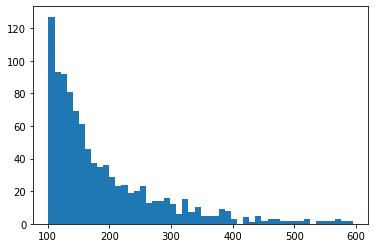

In [4]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [5]:
article_train_df

,item_id,user_id
5,10,"[872, 2209, 1328, 2581, 2758, 582, 705, 106, 1..."
10,1081,"[872, 864, 1150, 89, 2302, 2067, 2981, 1529, 1..."
11,1082,"[872, 864, 1150, 89, 2302, 2067, 2981, 1529, 1..."
12,1220,"[872, 2097, 1328, 1774, 705, 2545, 426, 490, 2..."
13,39,"[872, 1334, 2097, 3055, 739, 2758, 582, 1774, ..."
...,...,...
6419,374,"[2868, 1956]"
6451,7308,"[1854, 2163]"
6477,4859,"[1171, 2195]"
6504,7486,"[2312, 958]"


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

31.3240942387646


(array([2.468e+03, 7.140e+02, 4.360e+02, 2.570e+02, 1.550e+02, 1.380e+02,
        1.080e+02, 8.100e+01, 9.300e+01, 5.200e+01, 5.500e+01, 5.600e+01,
        4.200e+01, 2.900e+01, 3.700e+01, 3.000e+01, 3.000e+01, 1.700e+01,
        1.000e+01, 1.300e+01, 2.000e+01, 2.000e+01, 1.700e+01, 1.500e+01,
        7.000e+00, 6.000e+00, 1.000e+01, 1.200e+01, 1.000e+01, 1.100e+01,
        1.200e+01, 8.000e+00, 8.000e+00, 7.000e+00, 3.000e+00, 9.000e+00,
        2.000e+00, 4.000e+00, 8.000e+00, 8.000e+00, 4.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 7.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00]),
 array([  2.  ,   9.78,  17.56,  25.34,  33.12,  40.9 ,  48.68,  56.46,
         64.24,  72.02,  79.8 ,  87.58,  95.36, 103.14, 110.92, 118.7 ,
        126.48, 134.26, 142.04, 149.82, 157.6 , 165.38, 173.16, 180.94,
        188.72, 196.5 , 204.28, 212.06, 219.84, 227.62, 235.4 , 243.18,
        250.96, 258.74, 266.52, 274.3 , 282.08, 289.86, 297.64, 305.42,
        313.2 , 

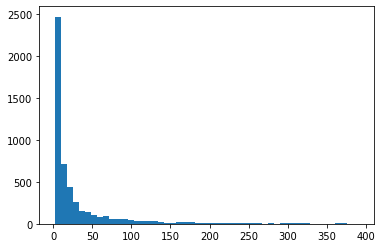

In [6]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [7]:
tests_df

,user_id,item_id,test_split
1528,1528,"[280, 19, 20, 21, 22, 23, 24, 25, 2090, 7547, ...","[([1155, 1688, 454, 4267, 183, 5117, 159, 468,..."
1246,1246,"[19, 21, 9, 8, 20, 1209, 1210, 1211, 280, 1619...","[([27, 153, 81, 148, 95, 96, 129, 2087, 152, 1..."
1724,1724,"[9, 280, 5110, 1410, 1222, 460, 83, 94, 95, 96...","[([1698, 1906, 1299, 1361, 190, 1907, 191, 103..."
2187,2187,"[9, 280, 1410, 1411, 68, 69, 63, 64, 83, 1229,...","[([1111, 1254, 1143, 1627, 1214, 2647, 1144, 2..."
1220,1220,"[1, 4, 6, 7, 280, 284, 19, 20, 21, 22, 23, 24,...","[([157, 395, 171, 763, 423, 432, 160, 178, 174..."
...,...,...,...
1563,1563,"[280, 1804, 17, 18, 19, 20, 21, 22, 23, 24, 25...","[([395, 10, 3251, 98, 2564, 2087, 110, 1803, 1..."
924,924,"[2738, 280, 16, 299, 1096, 1413, 110, 101, 156...","[([1301, 1442, 1910, 2009, 1911, 1443, 1342, 2..."
379,379,"[280, 19, 21, 20, 22, 23, 2089, 46, 47, 318, 3...","[([1913, 1586, 101, 517, 1291, 1643, 207, 3043..."
2824,2824,"[280, 19, 20, 21, 22, 23, 24, 25, 34, 1089, 39...","[([65, 110, 347, 2918, 139, 140, 1136, 814, 41..."


In [8]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

## 2. Functions or building association rules

In [9]:
def eclat(prefix, minsup, items, start=True):
    """
    Basic eclat implementation for finding frequent itemsets
    """
    frequents = []
    while items:
        i,itids = items.pop()
        isupp = len(itids)
        if isupp >= minsup:
            frequents.append((frozenset(prefix + [i]), isupp))
            suffix = [] 
            for j, ojtids in items:
                jtids = set(itids) & set(ojtids)
                if len(jtids) >= minsup:
                    suffix.append((j,jtids))
            frequents.extend(eclat(prefix+[i], minsup, sorted(suffix, key=lambda item: len(item[1]), reverse=True), False))
    return frequents

In [10]:
def subsets(itemset, include_empty_set=False):
    """ List all strict subsets of an itemset without the empty set or with the empty set if include_empty_set=True
        subsets({1,2,3}) --> [{1}, {2}, {3}, {1, 2}, {1, 3}, {2, 3}]
    """
    s = list(itemset)
    if include_empty_set:
        return map(set, chain.from_iterable(combinations(s, r) for r in range(0, len(s) + 1)))
    return map(set, chain.from_iterable(combinations(s, r) for r in range(1, len(s))))

In [11]:
def deriveRules(itemsets, minconf, test_users):
    """ Returns all rules with conf >= minconf that can be derived from the itemsets.
        Return: list of association rules in the format: [(antecedent, consequent, supp, conf), ...]
    """
    search_items = dict(itemsets)
    rules = []
    for item_set, supp in tqdm(itemsets):
        if len(item_set) > 1: # itemsets with one frequent item are unable to generate a rule
            for subset in subsets(item_set):  # for each subset generate a rule
                antecedent = frozenset(subset)
                consequent = item_set - subset
                if len(consequent)== 1: # only keep rules with one item in the consequent
                    conf = supp / search_items[antecedent]
                    if conf >= minconf: # assure confidence of the rule is high enough
                        # if test_users are passed, only generate rules with one of the test users in the consequent
                        if test_users:
                            if list(consequent)[0] in test_users:
                                rules.append(Association(antecedent, consequent, conf, supp))
                        else:
                            rules.append(Association(antecedent, consequent, conf, supp))
                        

    return rules

In [12]:
def genRules(min_conf, minsup, data, test_users = None):
    print("---Mining frequent itemsets---")
    frequent_itemsets = eclat([], minsup, sorted(data.items(), key=lambda item: len(item[1]), reverse=True))
    print(f"{len(frequent_itemsets)} frequent itemsets")
    c = 0
    for f in frequent_itemsets:
        if len(f[0]) == 1:
            c += 1
    print(f"{c} frequent itemsets of length 1")
    print("---Generating rules---")
    return deriveRules(frequent_itemsets, min_conf, test_users)

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [13]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
article_assos_rules = genRules(0.85, 50, data)

999
---Mining frequent itemsets---
3321424 frequent itemsets
999 frequent itemsets of length 1
---Generating rules---


100%|██████████████████████████████| 3321424/3321424 [01:17<00:00, 42614.43it/s]


CPU times: user 3min 12s, sys: 2.42 s, total: 3min 14s
Wall time: 3min 14s


In [14]:
len(article_assos_rules)

3800445

In [15]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

CPU times: user 556 ms, sys: 5.67 ms, total: 562 ms
Wall time: 564 ms


57626

In [16]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if r.s > 150:
        print(r)

### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [17]:
%%time
import copy
# user_assos_rules = genRules(0.0, 20, article_data)
print(len(article_data))
test_users = tests_df["user_id"].tolist()

rules_split = []

# build the datasets for training. We always add one part of the test set to the trainingset in order to create 4 different
# sets of user association rules
for i in range(4):
    print(f"Mining rules for split {i}")
    tmp = copy.deepcopy(article_data)
    for _, article in article_test_df.iterrows():
        # add the training split to the training data
        if article["item_id"] in tmp:
            tmp[article["item_id"]] += article["test_split"][i]
        else:
            tmp[article["item_id"]] = article["test_split"][i]
  
    # Build the user association rules with a minimum support of 40 and minimum confidence of 0.0
    r = genRules(0.0,40,tmp, test_users)
    rules_split.append(r)

5051
Mining rules for split 0
---Mining frequent itemsets---
1337990 frequent itemsets
1103 frequent itemsets of length 1
---Generating rules---


100%|██████████████████████████████| 1337990/1337990 [02:09<00:00, 10305.20it/s]


Mining rules for split 1
---Mining frequent itemsets---
1381902 frequent itemsets
1101 frequent itemsets of length 1
---Generating rules---


100%|███████████████████████████████| 1381902/1381902 [02:21<00:00, 9763.78it/s]


Mining rules for split 2
---Mining frequent itemsets---
1427120 frequent itemsets
1110 frequent itemsets of length 1
---Generating rules---


100%|███████████████████████████████| 1427120/1427120 [02:32<00:00, 9372.33it/s]


Mining rules for split 3
---Mining frequent itemsets---
1661958 frequent itemsets
1116 frequent itemsets of length 1
---Generating rules---


100%|██████████████████████████████| 1661958/1661958 [02:41<00:00, 10296.49it/s]

CPU times: user 11min 46s, sys: 3.77 s, total: 11min 49s
Wall time: 11min 48s


In [18]:
# print numebr of generated rules per split
for i in range(4):
    print(len(rules_split[i]))

172146
181766
181189
242085


See for how much test users we were able to create association rules and how many

In [19]:
corr = {}
test_users = tests_df["user_id"].tolist()
for user in test_users:
    for r in rules_split[3]:
        if user in list(r.right):
            if user in corr:
                corr[user] += 1
            else:
                corr[user] = 1

In [20]:
print(len(test_users))
print(len(corr))
print(corr)

101
30
{1246: 235, 1220: 4239, 915: 17, 2003: 3, 105: 643, 690: 369, 266: 490, 141: 679, 1620: 85, 554: 74, 603: 17, 2876: 7, 1225: 38, 74: 3418, 1627: 3, 213: 151867, 119: 1, 291: 255, 2520: 1, 1021: 231, 2362: 17, 1157: 52, 2162: 22, 192: 4, 201: 747, 1787: 9, 428: 19975, 1411: 22, 152: 58546, 1900: 19}


## 4. Normalize support / confidence to better use it later

In [21]:
"""
minc = 1
maxc = 0

mins = 9999999999999
maxs = -9999999999999
for a in article_assos_rules:
    if a.c < minc:
        minc = a.c
    if a.c > maxc:
        maxc = a.c
    
    if a.s < mins:
        mins = a.s
    if a.s > maxs:
        maxs = a.s
            
for a in article_assos_rules:
    a.c = (a.c - minc) / (maxc - minc)
    a.s = (a.s - mins) / (maxs - mins)
    # temp score that's just lhs + weighted average of c, s
    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))

"""

article_assos_rules = sorted(article_assos_rules, key = lambda x: x.score, reverse=True)
for i in article_assos_rules[:20]:
    print(i)


Conf: 0.93	Supp: 51.00	 {2992, 2155} => {1122}
Conf: 0.86	Supp: 50.00	 {2155, 403} => {83}
Conf: 0.88	Supp: 51.00	 {2155, 403} => {1389}
Conf: 0.94	Supp: 51.00	 {1122, 2155, 403} => {1389}
Conf: 0.93	Supp: 51.00	 {1122, 2155, 1389} => {403}
Conf: 1.00	Supp: 51.00	 {2155, 403, 1389} => {1122}
Conf: 0.91	Supp: 53.00	 {2155, 403} => {2982}
Conf: 0.93	Supp: 50.00	 {1122, 2155, 403} => {2982}
Conf: 0.91	Supp: 50.00	 {1122, 2155, 2982} => {403}
Conf: 0.94	Supp: 50.00	 {2155, 403, 2982} => {1122}
Conf: 0.93	Supp: 54.00	 {2155, 403} => {1122}
Conf: 0.86	Supp: 50.00	 {3184, 2155} => {1122}
Conf: 0.88	Supp: 51.00	 {3184, 2155} => {83}
Conf: 0.88	Supp: 51.00	 {3184, 2155} => {2982}
Conf: 0.88	Supp: 51.00	 {441, 2155} => {1389}
Conf: 0.90	Supp: 52.00	 {441, 2155} => {2982}
Conf: 0.90	Supp: 52.00	 {441, 2155} => {1122}
Conf: 0.88	Supp: 52.00	 {2155, 1276} => {1122}
Conf: 0.91	Supp: 51.00	 {2155, 1122, 83} => {2982}
Conf: 0.93	Supp: 51.00	 {1122, 2155, 2982} => {83}


## 5. Store the association rules as pickle file for further use

In [22]:
import pickle
pickle.dump(article_assos_rules, open("pickle_dumps/article_rules.p", "wb"))
pickle.dump(rules_split, open("pickle_dumps/user_rules.p", "wb"))